In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from collections import Counter
from math import isnan

import matplotlib.pyplot as plt

import re

In [2]:
# import os
# print (os.name)
# 'posix'

In [3]:
print('tensorflow version is {}'.format(tf.__version__))
print('numpy version is {}'.format(np.__version__))
print('pd version is {}'.format(pd.__version__))

tensorflow version is 1.0.0
numpy version is 1.12.0
pd version is 0.19.2


In [4]:
import getpass
# getpass.getuser()
# 'yarden'

user_opt = {
    'yarden' : {
        'data_path' : r'/media/yarden/OS/Users/Yarden-/Desktop/ETH Autumn 2016/Master Thesis/Data/20170303_EXPORT_for_Yarden.csv',
#         'data_path' : r'/home/yarden/git/Automated_categorization_medication/data/20170303_EXPORT_for_Yarden.csv',
        'atc_conversion_data_path' : r'/media/yarden/OS/Users/Yarden-/Desktop/ETH Autumn 2016/Master Thesis/Data/Complete_ATCs_and_lacking_translations_V03a_20161206.csv'
    },
    'Yarden-' : {
        'dummy_data_path' : None,
        'atc_conversion_data_path' : None
    }
}

cur_user = getpass.getuser()
user_opt = user_opt[cur_user]

In [5]:
main_data = pd.read_csv(user_opt['data_path'], 
                         sep=';', 
                         header=0, 
                         encoding='cp850')

atc_conversion_data = pd.read_csv(user_opt['atc_conversion_data_path'], 
                                  sep=';', 
                                  header=0, 
                                  encoding='cp850')

In [6]:
main_data.head(15)

,FREETXT,CNT,INGR,ATC,BestOutput,EnglishVsGerman,MoreATCs
0,NaCl 0.9%,315067,(Saline solution),B05B,(Sugar solution) or (Ringer's solution and var...,English,NaN
1,Dafalgan (Filmtabl 1 g) / Paracetamol 1000mg,56346,Paracetamol,N02BE01,Paracetamol,English,NaN
2,Fragmin (Inj L÷s 5000 E/0.2ml) Fertigspr / Dal...,54330,Dalteparin,B01AB04,Dalteparin,English,NaN
3,Perfalgan (Inf L÷s 1 g/100ml) Durchstf / Parac...,54235,Paracetamol,N02BE01,Paracetamol,English,NaN
4,Ringerfundin,53037,(Ringer's solution and variations),B05B,(Sugar solution) or (Ringer's solution and var...,English,NaN
5,Novalgin (Filmtabl 500 mg) / Metamizol 500mg,47530,Metamizol-Natrium,N02BB02,Metamizole sodium,English,NaN
6,Marcoumar (Tabl 3 mg) / Phenprocoumon 3mg,46118,Phenprocoumon,B01AA04,Phenprocoumon,English,NaN
7,Heparin,41495,Heparin,B01AB01,Heparin,English,NaN
8,Fragmin (Inj L÷s 5000 E/0.2ml) Fertspr / Dalte...,33946,Dalteparin,B01AB04,Dalteparin,English,NaN
9,Novaminsulfon SIN Injektionsl÷sung 50% Amp 2ml...,33211,Metamizol-Natrium,N02BB02,Metamizole sodium,English,NaN


In [7]:
# sum(main_data['FREETXT'] == main_data['INGR']) / float(main_data.shape[0])
# sum(main_data['FREETXT'] == main_data['BestOutput']) / float(main_data.shape[0])

In [8]:
atc_freq = Counter(main_data['ATC'])

# filter out 'nan'
atc_freq = {k: atc_freq[k] for k in atc_freq if isinstance(k, str)}
# atc_freq

In [9]:
print(
    'Number of observations: {}.'.format(sum(atc_freq.values())), '\n'
    'Number of ATC labels: {}.'.format(len(atc_freq.keys())), '\n'
    'Mean number of occurrences per ATC code: {:.3}.'.format(np.mean([float(k) for k in atc_freq.values()]))
)

Number of observations: 2028. 
Number of ATC labels: 558. 
Mean number of occurrences per ATC code: 3.63.


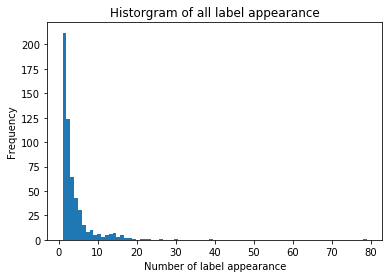

In [10]:
atc_label_freq = [v for v in atc_freq.values()]
hist, bins = np.histogram(atc_label_freq, 
                          bins=np.max(atc_label_freq))
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Number of label appearance')
plt.ylabel('Frequency')
plt.title('Historgram of all label appearance')
plt.show()

# fig, ax = plt.subplots()
# ax.bar(center, hist, align='center', width=width)
# fig.savefig("1.png")

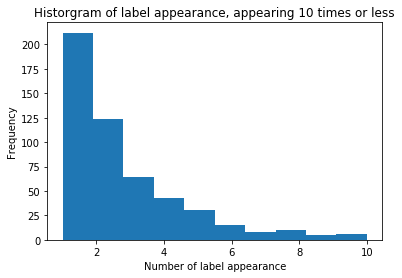

There are 212 labels that appear only once. 
This leaves 346 labels, 115 of which appear 5 times or more and 47 appearing at least 10 times


In [11]:
atc_label_freq_filtered = [v for v in atc_freq.values() if v <= 10]
hist, bins = np.histogram(atc_label_freq_filtered, 
                          bins=np.max(atc_label_freq_filtered))
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Number of label appearance')
plt.ylabel('Frequency')
plt.title('Historgram of label appearance, appearing 10 times or less')
plt.show()

appearing_once_labels = len([one for one in atc_label_freq if one == 1])
appearing_5more_labels = len([f for f in atc_label_freq if f >= 5])
appearing_10more_labels = len([f for f in atc_label_freq if f >= 10])

print('There are {} labels that appear only once.'.
      format(appearing_once_labels, ), 
      '\nThis leaves {} labels, {} of which appear 5 times or more and {} appearing at least 10 times'.
      format(len(atc_label_freq) - appearing_once_labels, 
             appearing_5more_labels, 
             appearing_10more_labels))

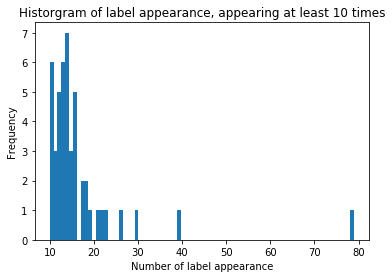

In [12]:
atc_label_freq_high_filtered = [v for v in atc_freq.values() if v >= 10]

hist, bins = np.histogram(atc_label_freq_high_filtered, 
                          bins=np.max(atc_label_freq_high_filtered))
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.xlabel('Number of label appearance')
plt.ylabel('Frequency')
plt.title('Historgram of label appearance, appearing at least 10 times')
plt.show()

In [13]:
atc_conversion_data.head(15)

,SummevonCNT,INGR,ATC,BestOutput,EnglishVsGerman,MoreATCs
0,29,Nortriptylin,N06AA10,Nortriptyline,English,NaN
1,29,Opipramol,N06AA05,Opipramol,English,NaN
2,29,Pindolol,C07AA03,Pindolol,English,NaN
3,29,Tenidap,M01AX23,Tenidap,English,NaN
4,28,Cocain,N01BC01,Cocaine,English,R02AD03;S01HA01;S02DA02
5,27,Diflucortolon,D07AC06,Diflucortolone,English,D07XC04
6,27,Flutamid,L02BB01,Flutamide,English,NaN
7,26,Carbomer,S01XA20,Artificial tears and other indifferent prepara...,English,NaN
8,26,Histamin-H2-Rezeptorantagonisten,A02BA,H2-receptor antagonists,English,NaN
9,25,Maprotilin,N06AA21,Maprotiline,English,NaN


In [14]:
# generate a dict of conversions,
# dropping keys that appear more than once (ambiguous)
atc_conversion_ingr_atc = {}
seen_keys = []
for j in range(len(atc_conversion_data)):
    key = atc_conversion_data['INGR'][j].split(' ')[0]
    # if key exists, delete and remember
    if key in atc_conversion_ingr_atc:
        del atc_conversion_ingr_atc[key]
        seen_keys.append(key)
    # if seen before, skip
    if key in seen_keys:
        continue
    # else add
    else:
        atc_conversion_ingr_atc[key] = atc_conversion_data['ATC'][j]

In [15]:
# removes characters from key, such as '(' and ')'.
atc_conversion_ingr_atc = {
    list(filter(None, re.compile(r"[;,()]").split(k)))[0]: atc_conversion_ingr_atc[k] 
    for k in atc_conversion_ingr_atc
}

# can verify:
# for key in atc_conversion_ingr_atc.keys():
#     print(key)
# or both key and ATC code
# for key in atc_conversion_ingr_atc.keys():
#     print('{}: {}'.format(key, atc_conversion_ingr_atc[key]))

In [16]:
# trying to find out if we can expand the dataset in a relatively cheap way
# does any of the FREETXT, currently unlabelled, 
# can be found in the ATC convertion table (not accurate, only indicative)
supplementary_candidates = {}
for txt in main_data['FREETXT'][main_data['CNT'] < 100]:
    freetxt_elements = list(filter(None, re.compile(r"[;,()]").split(txt)))
    atc_conversion_ingr_atc_keys = atc_conversion_ingr_atc.keys()
    if not set(freetxt_elements).isdisjoint(atc_conversion_ingr_atc_keys):
        currecnt_candidate = set(freetxt_elements).intersection(atc_conversion_ingr_atc_keys)
#         print('found one! It is {}. We have {} so far'.format(currecnt_candidate, counter))
#         print(atc_conversion_ingr_atc[list(currecnt_candidate)[0]])
        supplementary_candidates[txt] = atc_conversion_ingr_atc[list(currecnt_candidate)[0]]

# this list should be verified manually
# possible to generate an automatic URL
# to make verification a bit easier
# (repalce ATCCODE)
# URL=https://www.whocc.no/atc_ddd_index/?code=ATCCODE&showdescription=no
# consult with Carsten and Patrick, a physician should manually verify
# if so, export (to CSV?), clean some obvious mistakes and generate URLs
# 
# supplementary_candidates